## Import Libs

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

2024-04-17 19:52:02.997129: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 19:52:03.362971: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 19:52:04.244134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Env Initialization

In [2]:
env = gym.make("Pendulum-v1")

num_states = env.observation_space.shape[0]
print(f"Size of State Space ->  {num_states}")
num_actions = env.action_space.shape[0]
print(f"Size of Action Space ->  {num_actions}")

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print(f"Max Value of Action ->  {upper_bound}")
print(f"Min Value of Action ->  {lower_bound}")

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


## Generate Noise

In [3]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

## Experience Replay

In [4]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

## Actor & Critic Nets

In [5]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

## Policy

In [6]:
def policy(state, noise_object):
    sampled_actions = tf.keras.ops.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

## Hyperparameters

In [7]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
max_iterations = 100
gamma = 0.99
tau = 0.005

buffer = Buffer(50000, 64)

render = True

2024-04-17 19:52:05.876171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 19:52:05.876536: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Render ?

In [8]:
if render:
    env = gym.make("Pendulum-v1", render_mode="rgb_array")
    frames_dir = "../../data/frames/ddpg"
    os.makedirs(os.path.dirname(frames_dir), exist_ok=True)
else:
    env = gym.make("Pendulum-v1")

## Train

/home/elesdes/miniconda3/envs/5IABD_PA/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0 | Avg Reward is ==> -690.9425929076006
Episode 1 | Avg Reward is ==> -686.0898517226615
Episode 2 | Avg Reward is ==> -679.6576374359291
Episode 3 | Avg Reward is ==> -640.1207490456223
Episode 4 | Avg Reward is ==> -641.6619422521748
Episode 5 | Avg Reward is ==> -682.508531704049
Episode 6 | Avg Reward is ==> -714.0113378691564
Episode 7 | Avg Reward is ==> -719.638556321356
Episode 8 | Avg Reward is ==> -738.3137622899956
Episode 9 | Avg Reward is ==> -736.0603326133742
Episode 10 | Avg Reward is ==> -730.0248381528313
Episode 11 | Avg Reward is ==> -733.3221957188563
Episode 12 | Avg Reward is ==> -742.6362130820615
Episode 13 | Avg Reward is ==> -732.0634360289872
Episode 14 | Avg Reward is ==> -739.9829546454566
Episode 15 | Avg Reward is ==> -737.0037335380944
Episode 16 | Avg Reward is ==> -726.6061979709864
Episode 17 | Avg Reward is ==> -733.4623653460644
Episode 18 | Avg Reward is ==> -737.4156623304561
Episode 19 | Avg Reward is ==> -740.1204694181968
Episode 20 |

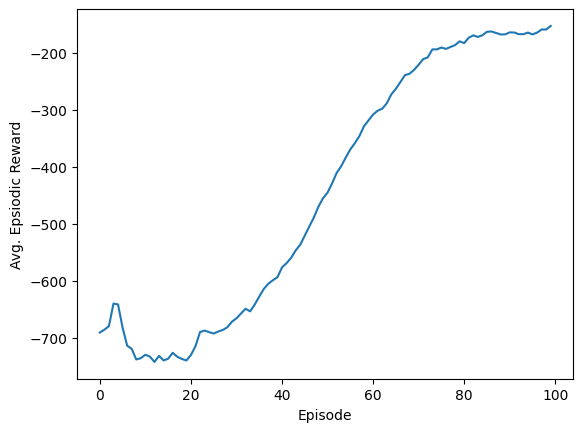

In [9]:
import imageio

ep_reward_list = []
avg_reward_list = []

for epoch in range(total_episodes):

    prev_state, _ = env.reset()
    episodic_reward = 0
    counter = 0

    while True and counter <= max_iterations:
        if render:
            frame = env.render()
            frame_path = os.path.join(frames_dir, f"epoch_{epoch}_step_{counter+1}.png")
            imageio.imwrite(frame_path, frame)
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        state, reward, done, info, _ = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        if done:
            break

        prev_state = state
        
        counter += 1

    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    print(f"Episode {epoch} | Avg Reward is ==> {avg_reward}")
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

## Generate Video Of Training


In [10]:
import os
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from datetime import datetime

# Assuming frames_dir is already defined
filenames = sorted(
    [os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith(".png")]
)

# Specify the font and size for the text
font = ImageFont.load_default()  # Use a default font. Adjust if needed.

video_dir = f"../../data/videos/ddpg"
os.makedirs(video_dir, exist_ok=True)

with imageio.get_writer(os.path.join(video_dir, f"/training_video_{datetime.now().strftime('%d%m%Y%H%M%S')}.mp4"), fps=30) as video:
    for filename in tqdm(filenames):
        # Extract epoch and frame from the filename
        parts = filename.split('_')
        epoch_num = parts[1]
        frame_num = parts[3].split('.')[0]
        
        # Load the image
        img = Image.open(filename)
        draw = ImageDraw.Draw(img)
        
        # Prepare text
        text = f"Epoch: {epoch_num}, Step: {frame_num}"
        
        # Position: (x, y) from the bottom left corner
        text_position = (10, img.height - 20)
        
        # Draw text
        draw.text(text_position, text, font=font, fill=(0, 0, 0))
        
        # Convert the Pillow Image to a NumPy array
        img_array = np.array(img)
        
        # Append image to video
        video.append_data(img_array)

"""# Optionally, clean up by removing the images if no longer needed
for filename in filenames:
    os.remove(filename)
os.rmdir(frames_dir)"""

  0%|          | 1/20200 [00:00<55:22,  6.08it/s]


OSError: [Errno 32] Broken pipe

FFMPEG COMMAND:
/home/elesdes/miniconda3/envs/5IABD_PA/lib/python3.11/site-packages/imageio_ffmpeg/binaries/ffmpeg-linux64-v4.2.2 -y -f rawvideo -vcodec rawvideo -s 500x500 -pix_fmt rgb24 -r 30.00 -i - -an -vcodec libx264 -pix_fmt yuv420p -vf scale=512:512 -v warning /training_video_17042024200541.mp4

FFMPEG STDERR OUTPUT:
